<a href="https://colab.research.google.com/github/davidnol/ET5003_SEM1_2021-2/blob/main/ET5003_Etivity_2_David_Nolan_20146744.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '2021-10-01' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20146744" #@param {type:"string"}
Student_full_name = "David Nolan " #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Practice' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

In [6]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [7]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The challenge is to predict the final price of each house.

## Loading & visualising data


In [9]:
# Path, copy the path from your Drive
Path = '/content/drive/MyDrive/Colab Notebooks/DavidNolan/House Data/'

# House Data
train_data = Path + 'house_train.csv'
test_data = Path + 'house_test.csv'
cost_data = Path + 'true_price.csv'

# train data
df_train = pd.read_csv(train_data)
print(df_train.shape)

# test data
df_test = pd.read_csv(test_data)
print(df_test.shape)

# cost data
df_cost = pd.read_csv(cost_data)
print(df_cost.shape)

(2982, 17)
(500, 16)
(500, 2)


### **EDA - Train Dataset**

In [10]:
df_train.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [11]:
df_train.tail()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
2977,12428232,Ballsbridge,2.0,2.0,C3,Dublin,Sherry FitzGerald are delighted to present Apa...,prod,NaN,Prime Location\nManagement Co: Core Property M...,53.338738,-6.237199,NaN,415000.0,sale,apartment,56.0
2978,12428240,Rialto,1.0,3.0,B2,Dublin,Property Team Patrick Moran is delighted to pr...,prod,NaN,Totally refurbished to the highest standard. \...,53.335793,-6.294268,NaN,485000.0,sale,terraced,101.0
2979,12428247,Smithfield,1.0,2.0,C3,Dublin,Earnest estate agents are delighted to present...,prod,Wired for Cable Television,OVERLOOKING THE RIVER LIFFEY \n3RD FLOOR APART...,53.346098,-6.276856,NaN,299000.0,sale,apartment,55.6
2980,12428254,Foxrock,2.0,3.0,C3,Dublin,Janet Carroll Estate Agents are pleased to pre...,prod,"Parking,Gas Fired Central Heating",None,53.273518,-6.178500,NaN,495000.0,sale,end-of-terrace,97.0
2981,12428358,Terenure,2.0,3.0,D2,Dublin,ON VIEW SATURDAY 7 TH MARCH 2020 11:30 AM - 12...,prod,NaN,Charming three-bedroom family home\nMinutes aw...,53.310073,-6.325158,NaN,525000.0,sale,semi-detached,129.3


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2982 entries, 0 to 2981
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ad_id               2982 non-null   int64  
 1   area                2982 non-null   object 
 2   bathrooms           2931 non-null   float64
 3   beds                2931 non-null   float64
 4   ber_classification  2305 non-null   object 
 5   county              2982 non-null   object 
 6   description_block   2982 non-null   object 
 7   environment         2982 non-null   object 
 8   facility            965 non-null    object 
 9   features            2982 non-null   object 
 10  latitude            2982 non-null   float64
 11  longitude           2982 non-null   float64
 12  no_of_units         59 non-null     float64
 13  price               2892 non-null   float64
 14  property_category   2982 non-null   object 
 15  property_type       2931 non-null   object 
 16  surfac

In [13]:
df_train.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


In [14]:
df_train.isna().sum()

ad_id                    0
area                     0
bathrooms               51
beds                    51
ber_classification     677
county                   0
description_block        0
environment              0
facility              2017
features                 0
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

In [15]:
# Find the number of nulls/NaNs in the dataset as a percentage to see if any columns need to be considered for removal
print("Read of missing values as percentage of data set")
df_train.isna().sum()*100/len(df_train)

Read of missing values as percentage of data set


ad_id                  0.000000
area                   0.000000
bathrooms              1.710262
beds                   1.710262
ber_classification    22.702884
county                 0.000000
description_block      0.000000
environment            0.000000
facility              67.639168
features               0.000000
latitude               0.000000
longitude              0.000000
no_of_units           98.021462
price                  3.018109
property_category      0.000000
property_type          1.710262
surface               18.477532
dtype: float64

In [16]:
df_train['beds'].value_counts()

3.0     1009
2.0      806
4.0      583
1.0      209
5.0      187
0.0       56
6.0       44
7.0       20
8.0        4
9.0        4
15.0       3
27.0       2
11.0       2
10.0       1
14.0       1
Name: beds, dtype: int64

In [17]:
df_train['ber_classification'].value_counts()

D1                     283
D2                     274
C3                     268
C2                     242
C1                     212
E1                     182
E2                     169
G                      166
F                      165
B3                     130
B2                      74
A3                      70
SINo666of2006exempt     28
A2                      25
B1                      16
A1                       1
Name: ber_classification, dtype: int64

In [18]:
df_train['property_type'].value_counts()

apartment         759
semi-detached     754
terraced          554
detached          398
end-of-terrace    237
bungalow           84
duplex             60
site               55
townhouse          27
studio              3
Name: property_type, dtype: int64

In [19]:
df_train['no_of_units'].value_counts()

3.0     12
2.0      9
1.0      6
8.0      4
6.0      4
4.0      4
0.0      3
5.0      2
7.0      2
30.0     1
24.0     1
9.0      1
35.0     1
14.0     1
36.0     1
16.0     1
12.0     1
32.0     1
23.0     1
15.0     1
19.0     1
18.0     1
Name: no_of_units, dtype: int64

### EDA - Test dataset

In [20]:
# show first data frame rows 
df_test.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0


In [21]:
df_test.tail()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
495,12369815,Ringsend,1.0,2.0,NaN,Dublin,***SUPERB LOCATION / PRIVATE PARKING OPTION AV...,prod,NaN,Adjacent to Grand Canal Dock\nClose to a host ...,53.342207,-6.226101,NaN,sale,apartment,65.0
496,12416011,Cabinteely,3.0,5.0,E1,Dublin,"OPEN VIEWING SATURDAY 7TH MARCH, 10.00AM - 10....",prod,"Parking,Alarm,Oil Fired Central Heating",Excellently presented 5 bedroom family home\nE...,53.261475,-6.147720,NaN,sale,detached,191.3
497,12232222,Artane,1.0,3.0,G,Dublin,Sherry FitzGerald is delighted to present to t...,prod,NaN,Detached Family Home\nOnly One Owner\nMature C...,53.391619,-6.205157,NaN,sale,detached,105.0
498,11905630,Clontarf,2.0,4.0,E2,Dublin,Modernised yet still in touch with it's period...,prod,"Parking,Gas Fired Central Heating,Alarm,Wired ...",Stunning coastal views.\nExcellent condition t...,53.360578,-6.183701,NaN,sale,end-of-terrace,130.0
499,12394865,Drumcondra,2.0,2.0,C1,Dublin,MOVEHOME ESTATE AGENTS .. are delighted to pre...,prod,NaN,* Spacious two Bedroom master ensuite apartmen...,53.366827,-6.248329,NaN,sale,apartment,71.0


In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ad_id               500 non-null    int64  
 1   area                500 non-null    object 
 2   bathrooms           500 non-null    float64
 3   beds                500 non-null    float64
 4   ber_classification  444 non-null    object 
 5   county              500 non-null    object 
 6   description_block   500 non-null    object 
 7   environment         500 non-null    object 
 8   facility            189 non-null    object 
 9   features            500 non-null    object 
 10  latitude            500 non-null    float64
 11  longitude           500 non-null    float64
 12  no_of_units         0 non-null      float64
 13  property_category   500 non-null    object 
 14  property_type       500 non-null    object 
 15  surface             500 non-null    float64
dtypes: float

In [23]:
df_test.isna().sum()

ad_id                   0
area                    0
bathrooms               0
beds                    0
ber_classification     56
county                  0
description_block       0
environment             0
facility              311
features                0
latitude                0
longitude               0
no_of_units           500
property_category       0
property_type           0
surface                 0
dtype: int64

### EDA - Expected Cost dataset

In [24]:
df_cost.head()

,Id,Expected
0,12373510,875000.0
1,12422623,355000.0
2,12377408,440000.0
3,12420093,425000.0
4,12417338,265000.0


In [25]:
df_cost.tail()

,Id,Expected
495,12369815,345000.0
496,12416011,775000.0
497,12232222,360000.0
498,11905630,925000.0
499,12394865,325000.0


In [26]:
# Generate descriptive statistics
df_cost.describe()

,Id,Expected
count,5.000000e+02,5.000000e+02
mean,1.231695e+07,5.810356e+05
std,1.485832e+05,6.009194e+05
min,1.130615e+07,8.500000e+04
25%,1.228617e+07,2.950000e+05
50%,1.237964e+07,4.250000e+05
75%,1.240544e+07,5.950000e+05
max,1.242809e+07,5.750000e+06


### Data Prep

In [27]:
# Drop the Text Based Features, Low Value Features
drop_features = ['ad_id', 'description_block', 'environment', 'county', 'no_of_units', 'facility',
                 'property_category', 'features', 'area']

df_train_new = df_train.drop(drop_features, axis=1)
df_test_new = df_test.drop(drop_features, axis=1)

In [28]:
df_train_new.head()

,bathrooms,beds,ber_classification,latitude,longitude,price,property_type,surface
0,NaN,NaN,NaN,53.418216,-6.149329,NaN,NaN,NaN
1,NaN,NaN,NaN,53.364917,-6.454935,NaN,NaN,NaN
2,NaN,NaN,NaN,53.273447,-6.313821,NaN,NaN,NaN
3,NaN,NaN,NaN,53.608167,-6.210914,NaN,NaN,NaN
4,NaN,NaN,NaN,53.262531,-6.181527,NaN,NaN,NaN


In [29]:
# Replace all ber values with equivalant decimal values. Last value is 'nan' so ignore that
df_train_new.dropna(subset=['ber_classification'], inplace=True)
ber_features = df_train_new['ber_classification'].sort_values().unique()

new_ber_values = np.arange(1, len(ber_features) + 1).tolist()

df_train_new['ber_classification'].replace(to_replace=ber_features,
                                      value=new_ber_values,
                                      inplace=True)

df_test_new.dropna(subset=['ber_classification'], inplace=True)
df_test_new['ber_classification'].replace(to_replace=ber_features,
                                      value=new_ber_values,
                                      inplace=True)

In [30]:
# Replace property type
replace_ptype_features = ['apartment', 'studio', 'duplex', 'townhouse', 'terraced', 'end-of-terrace',
                          'semi-detached', 'detached', 'bungalow', 'site' ]

replace_values = np.arange(1, len(replace_ptype_features) + 1).tolist()

# Apply basic conversion to the property type
df_train_new['property_type'].replace(to_replace=replace_ptype_features,
                                      value=replace_values,
                                      inplace=True)

df_test_new['property_type'].replace(to_replace=replace_ptype_features,
                                      value=replace_values,
                                      inplace=True)
# Remove columns with 0 - causes problems for the scalers used below
df_train_new = df_train_new[(df_train_new.beds>0)]

# Also drops all sites - this is intended
df_train_new = df_train_new[(df_train_new.bathrooms>0)]

df_train_new = df_train_new[(df_train_new.price>0)]

In [31]:
#Calculate statistics for the categorical attributes.
print(df_train_new.select_dtypes(exclude=['object']).isna().sum())

bathrooms               0
beds                    0
ber_classification      0
latitude                0
longitude               0
price                   0
property_type           0
surface               279
dtype: int64


In [32]:
df_train_new.describe(include='all')

,bathrooms,beds,ber_classification,latitude,longitude,price,property_type,surface
count,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2.268000e+03,2268.000000,1989.000000
mean,2.029982,3.011464,9.881834,53.352355,-6.254128,5.296808e+05,5.046296,163.741150
std,1.105379,1.185804,3.140184,0.086984,0.120985,4.491815e+05,2.709273,1636.793536
min,1.000000,1.000000,1.000000,51.458439,-6.521183,1.000000e+05,1.000000,22.450000
25%,1.000000,2.000000,8.000000,53.293862,-6.309139,2.950000e+05,1.000000,74.000000
50%,2.000000,3.000000,10.000000,53.342357,-6.247185,3.950000e+05,6.000000,99.600000
75%,3.000000,4.000000,12.000000,53.384557,-6.189523,5.950000e+05,7.000000,140.000000
max,15.000000,15.000000,16.000000,53.630588,-2.496219,7.950000e+06,10.000000,72236.387140


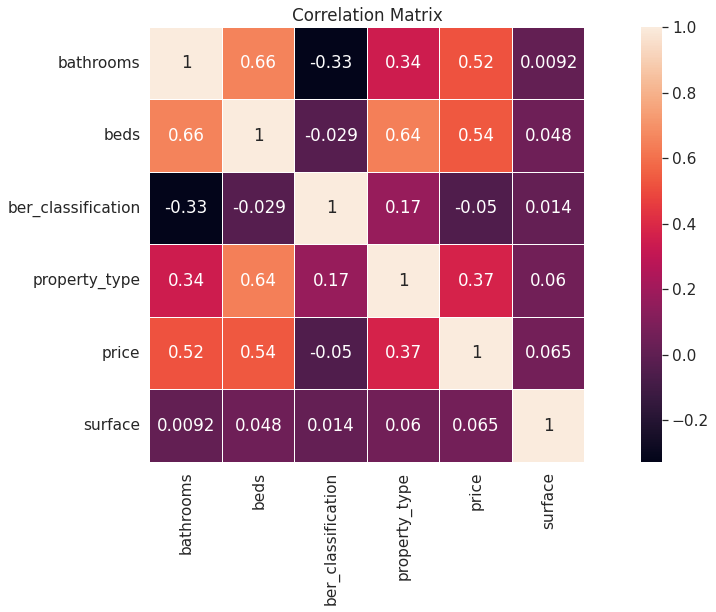

In [33]:
# Check relationships between numerical variables
import seaborn as sns
df_train_new[['bathrooms','beds','ber_classification','property_type','price','surface']].dropna()

sns.set(font_scale=1.4)
plt.figure(figsize=(20, 8))
plt.title('Correlation Matrix')
sns.heatmap(df_train_new[['bathrooms','beds','ber_classification','property_type','price','surface']].corr(),linewidths=0.01,
            square=True,annot=True)

Beds and bathrooms have a strong relationshiop of 0.66 meaning that number of bathrooms increase with the number of beds. There is a positive relationship of 0.54 between number of beds and price. Also 0.64 for beds and property type.


### Dectection & Removal of Outliers

In [34]:
# First filter out those rows which
# does not contain any data
df_train_new = df_train_new.dropna(how = 'any')
df_train_new.drop(df_train_new[df_train_new['beds'] == 0].index, inplace = True)
df_train_new.drop(df_train_new[df_train_new['bathrooms'] == 0].index, inplace = True)
print(df_train_new.select_dtypes(exclude=['object']).isna().sum())

bathrooms             0
beds                  0
ber_classification    0
latitude              0
longitude             0
price                 0
property_type         0
surface               0
dtype: int64


In [35]:
# Function to Detection Outlier on one-dimentional datasets.
def remove_outliers(dframe, feature):
    '''Function to Detect / Remove Outliers'''
  
    #define a list to accumlate anomalies
    anomalies = []
    
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(dframe[feature])
    random_data_mean = np.mean(dframe[feature])
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    
    dframe = dframe.drop(dframe[(dframe[feature] < lower_limit) | (dframe[feature] > upper_limit)].index)

    return dframe

def plot_box_hist(dframe, features):
    '''Function to plot Box / Histogram pair for any feature'''
    no_feats = len(features)
  
    figH = plt.figure(figsize=(30,no_feats*5))

    for i in range(0, no_feats): 
        ax1 = figH.add_subplot(no_feats, 2, (i*2)+1)
        ax1.set_title("Boxplot of "+features[i])
        dframe.boxplot(column=[features[i]])

        ax2 = figH.add_subplot(no_feats, 2, (i*2)+2)
        ax2.set_title("Histogram of "+features[i])
        dframe[features[i]].hist(bins=20)

    plt.show()

Analysis of outliers


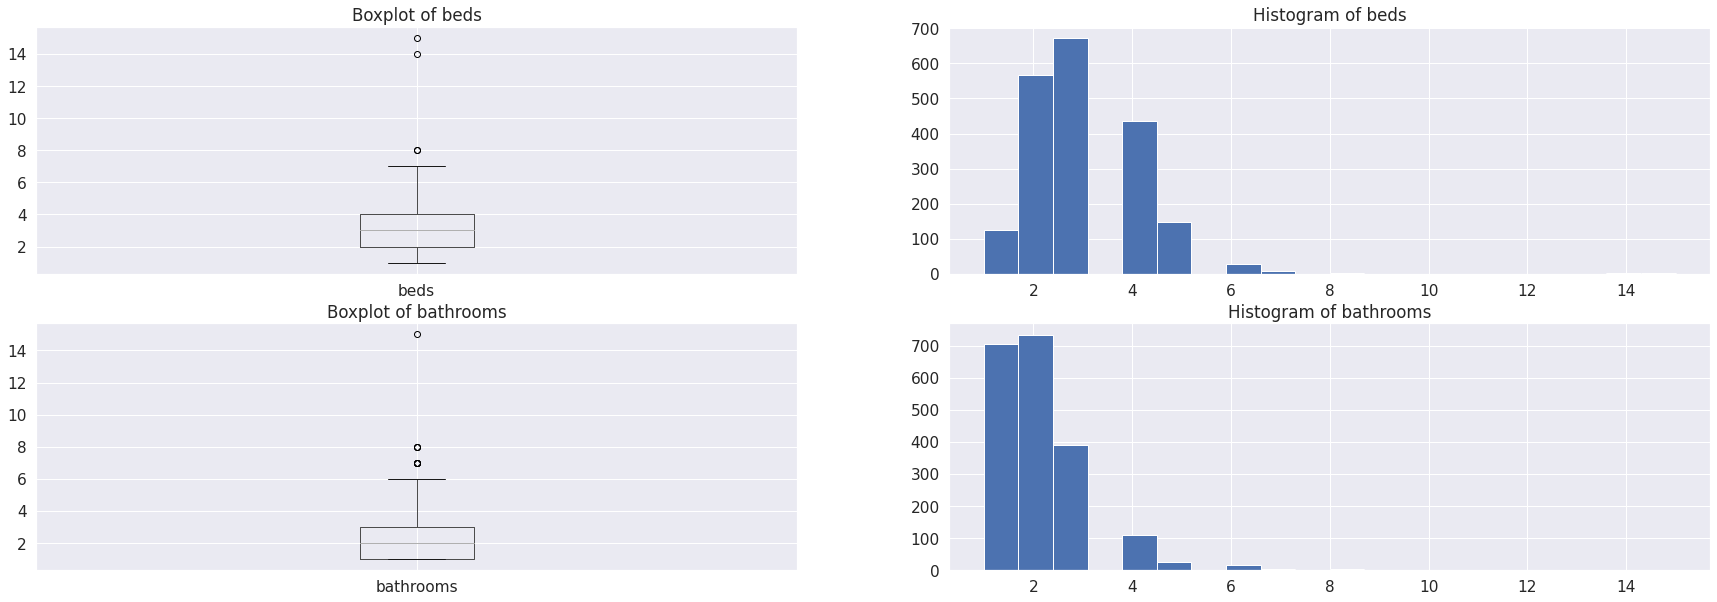

(1989, 8)
After outliers have been removed


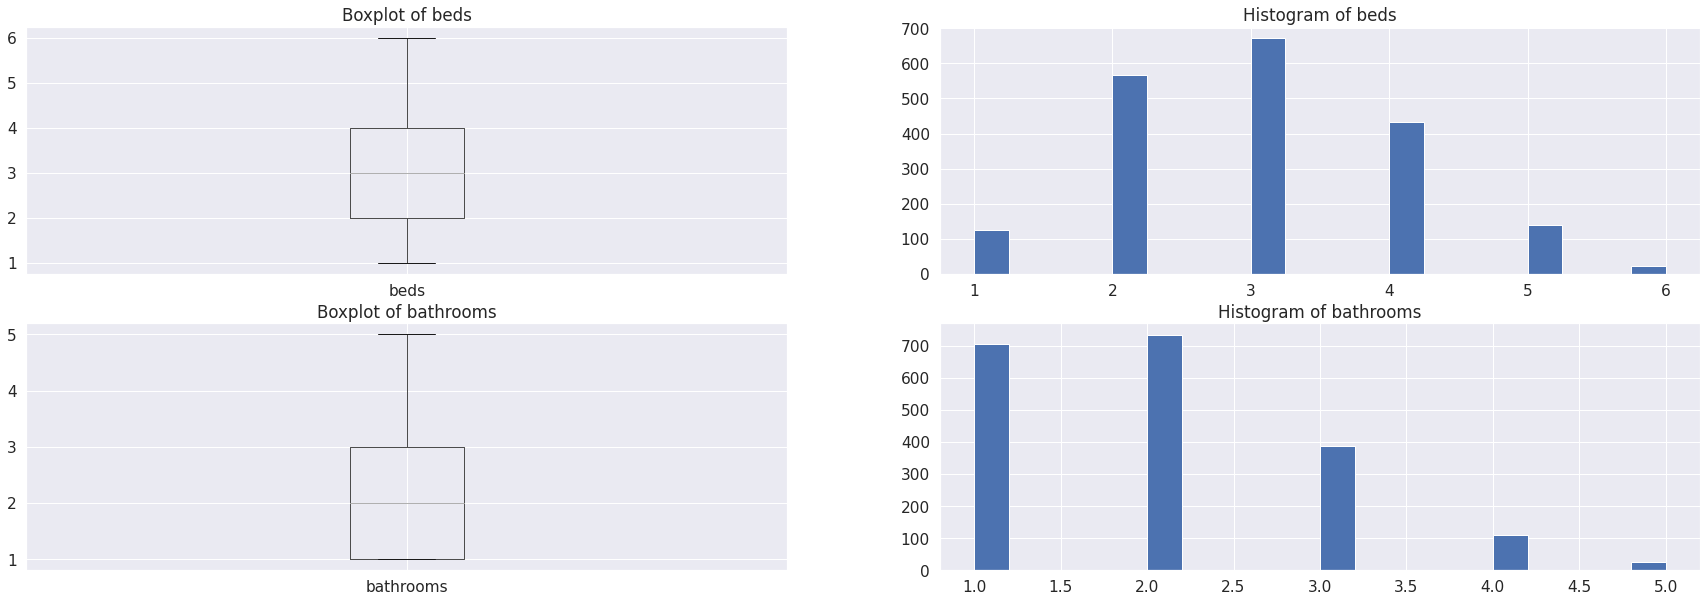

(1961, 8)


In [36]:
#Select features to include in plots
include_featues = ['beds','bathrooms']

#run print function
print("Analysis of outliers")
plot_box_hist(df_train_new, include_featues)
print(df_train_new.shape)

print("After outliers have been removed")
for i in range(0, len(include_featues)): 
    df_train_new = remove_outliers(df_train_new,include_featues[i])

#run print function
plot_box_hist(df_train_new, include_featues)
print(df_train_new.shape)

In [37]:
# Drop  location inconsistent with county Dublin
InconsistentLongitude = df_train_new[df_train_new['longitude'] > -6].index
df_train_new.drop(InconsistentLongitude, inplace=True)

In [38]:
# show first data frame rows 
df_train_new.head()

,bathrooms,beds,ber_classification,latitude,longitude,price,property_type,surface
15,3.0,5.0,3,53.400454,-6.445730,935000.0,8,321.0
26,4.0,4.0,3,53.316410,-6.385214,485000.0,7,144.0
27,3.0,5.0,3,53.401414,-6.446634,935000.0,8,321.0
35,5.0,5.0,2,53.375377,-6.056749,1475000.0,8,312.0
38,2.0,2.0,3,53.372130,-6.338466,410000.0,1,83.0


In [39]:
# show first data frame rows 
df_test_new.head()

,bathrooms,beds,ber_classification,latitude,longitude,property_type,surface
0,2.0,4.0,15,53.566881,-6.101148,9,142.0
1,2.0,3.0,7,53.362992,-6.452909,5,114.0
2,3.0,4.0,6,53.454198,-6.262964,7,172.0
3,4.0,3.0,3,53.354402,-6.458647,7,132.4
4,1.0,3.0,13,53.336530,-6.393587,7,88.0


In [40]:
df_cost.head()

,Id,Expected
0,12373510,875000.0
1,12422623,355000.0
2,12377408,440000.0
3,12420093,425000.0
4,12417338,265000.0


In [41]:
print('Orginal train shape') 
print(df_train.shape)
print('New train shape')
print(df_train_new.shape)
print('Orginal test shape') 
print(df_test.shape)
print('New test shape') 
print(df_test_new.shape)
print('Cost shape') 
print(df_cost.shape)

Orginal train shape
(2982, 17)
New train shape
(1961, 8)
Orginal test shape
(500, 16)
New test shape
(444, 7)
Cost shape
(500, 2)


# PIECEWISE REGRESSION

In [42]:
# split data into training and test
from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
X = df_train_new.drop("price",axis=1)
y = df_train_new["price"]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

## Full Model

In [43]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful

featrain = ['beds','bathrooms', 'latitude','longitude', 'price']

# dropna: remove missing values
df_subset_train = df_train_new[featrain].dropna(axis=0)

# Test data
featest = ['beds', 'bathrooms', 'latitude','longitude']
df_subset_test = df_test_new[featest].dropna(axis=0)

# cost
df_cost = df_cost[df_cost.index.isin(df_subset_test.index)]

In [44]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [45]:
# train set, input columns
Xs_train = X_train
# train set, output column, cost
ys_train = y_train.values.reshape(-1,1) 

# test set, input columns
Xs_test = df_test_new.iloc[:,0:].values 
# test set, output column, cost
y_test = df_cost.Expected.values

In [46]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

# Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xs_train)
Xn_train = xscaler.transform(Xs_train)

#Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xs_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [47]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 1,335.3


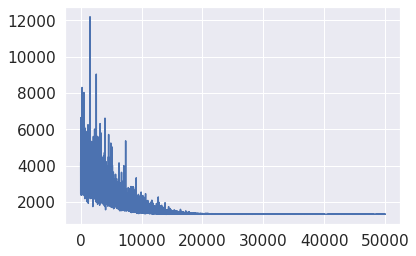

In [48]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [49]:
# samples from the posterior
posterior = approximation.sample(5000)

In [50]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  172627.77186378863
MAPE =  0.26691298187939827


For context before mapping and including property type and BER my MAE and MAPE were:

MAE =  211147.7267215982

MAPE =  0.29209389305565436

Peer gets:


MAE =  174362.0076747574

MAPE =  0.26896907851563795

Now when including BER and property type get:

MAE: 172627.77186378863

MAPE: 0.29209389305565436


## Clustering

### Full Model

In [51]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4)
ind=[2,3]

X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

### Clusters

In [52]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 83, 1: 500, 2: 304, 3: 485}

In [53]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 40, 1: 150, 2: 108, 3: 146}

In [54]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [55]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [56]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [57]:

# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

## Piecewise Model

In [58]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 137.67


In [59]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 511.36


In [60]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 183.68


In [61]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)


Finished [100%]: Average Loss = 454.35


##Simulations

In [62]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

### Only Cluster 0

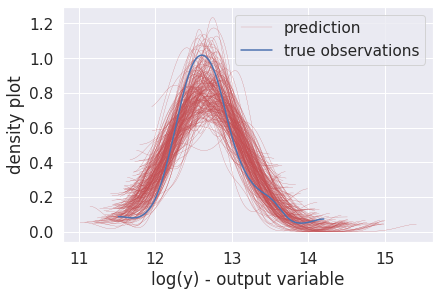

In [63]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 1

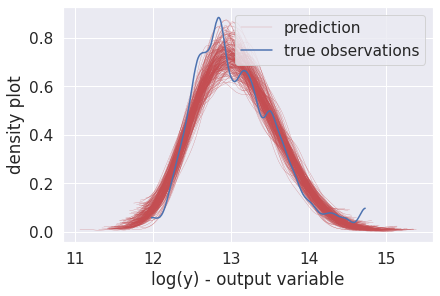

In [64]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 2

Text(0, 0.5, 'density plot')

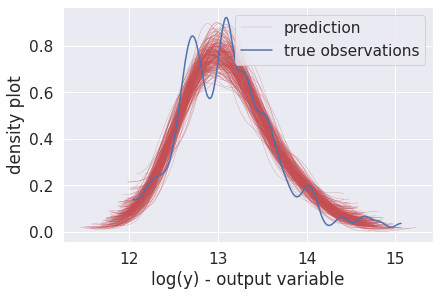

In [65]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot")

### Only Cluster 3

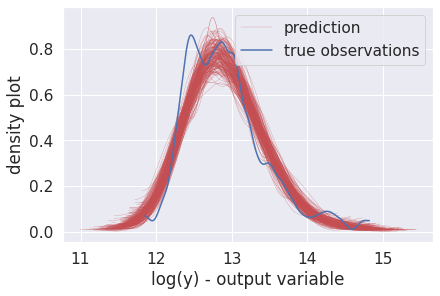

In [66]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

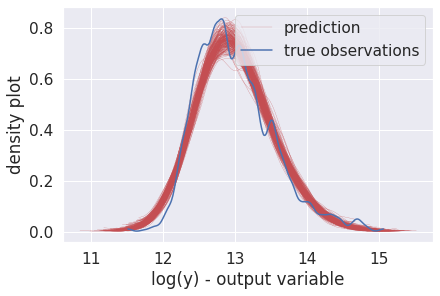

In [67]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [68]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3])])

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 40 , MAE Cluster0= 93477.36923832094
Size Cluster1 150 , MAE Cluster1= 200919.9455971751
Size Cluster2 108 , MAE Cluster2= 137207.8314858344
Size Cluster3 146 , MAE Cluster3= 118576.93552826197
MAE= 148666.1373799673


### PPC on the Test set



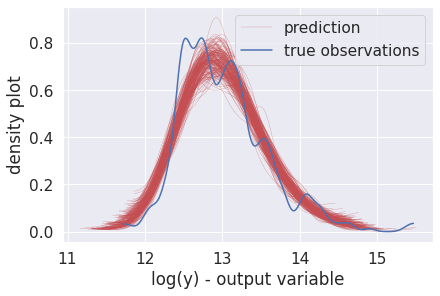

In [69]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

This prediction error is calculated for each record of the test data set. After, we convert each error to a positive figure if negative. This is achieved by taking Absolute value for each error. Finally we calculate the mean value for all recorded absolute errors. (Average sum of all absolute errors). In our above example this would be actual cost vs perdicted cost of houses based on certain criteria. Prediction Error => Actual Cost - Predicted Cost. MAE = (Absolute Error 1 + Absolute Error 2 + Absolute Error 3 + Absolute Error 4+ Absolute Error 5) / n

# SUMMARY

# REFERENCES 
*   Mean Absolute Error (MAE) ~ Sample Calculation [link text](https://medium.com/@ewuramaminka/mean-absolute-error-mae-sample-calculation-6eed6743838a)
*   XXXX